In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pylab
import os
from datetime import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub

from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import classification_report

# Load the TensorBoard notebook extension.
%load_ext tensorboard

In [13]:
df_shoes = pd.read_csv('post_analysis_shoes.csv')
df_shoes.shape

(8064, 18)

In [14]:
def plot_value_counts(df,column,kind,rotation=None):
    if(kind == 'barh'):
        plt.figure(figsize=(10,25))
    else:
        plt.figure(figsize=(16,5))
    (df[column].value_counts()/len(df)).plot(kind=kind,title=f"{column}")
    if(rotation):
        plt.xticks(rotation=rotation)
    plt.show()

['feminino', 'masculino', 'unissex']


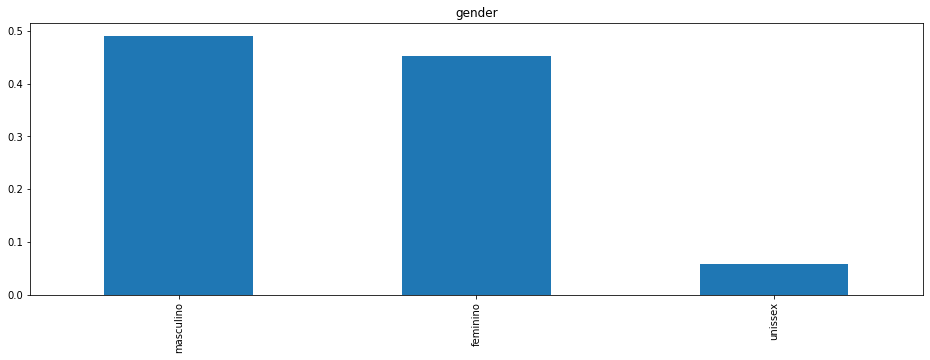

In [15]:
print(list(df_shoes['gender'].unique()))
    
plot_value_counts(df_shoes,'gender','bar')

# Preprocessing Functions

In [16]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [17]:
base_path = '/home/raphael/Documents/Projects/netshoes_ml_project/netshoes/images/'
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            rotation_range=45,
                                            width_shift_range=.15,
                                            height_shift_range=.15,
                                            horizontal_flip=True,
                                            zoom_range=0.5)

validation_image_generator = ImageDataGenerator(rescale=1./255)

In [18]:
IMG_SHAPE = (240,240)
epochs = 80

checkpoint_path = './gender_model/drop35_lr2e4_adam_b1'

In [8]:
efficient_net_url = "https://tfhub.dev/google/efficientnet/b1/feature-vector/1"

drop_rate = 0.35
if(not os.path.exists(checkpoint_path)):
    os.makedirs(checkpoint_path)

    feature_extractor_layer = hub.KerasLayer(efficient_net_url,
                                         input_shape=IMG_SHAPE+(3,))
    feature_extractor_layer.trainable = False

    model = Sequential([
        feature_extractor_layer,
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(256,'elu'),
        Dropout(drop_rate),
        BatchNormalization(),
        Dense(128,'elu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(64,'elu'),
        Dropout(0.2),
        BatchNormalization(),
        Dense(32,'elu'),
        Dropout(0.1),
        BatchNormalization(),
        Dense(df_shoes['gender'].nunique())
    ])
    initial_epoch = 0
else:
    model = tf.keras.models.load_model(checkpoint_path)
    initial_epoch = epochs

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1280)              6575232   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_10 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 128)              

In [19]:
df_shoes['images'] = df_shoes['images'].str.split(',')
df_data = df_shoes.explode('images')[['images','gender']]
df_data['images'] = base_path + df_data['images']
df_data.shape

(35391, 2)

In [20]:
train, valid_test = train_test_split(df_data,
                                test_size=0.15,
                                stratify=df_data['gender'].values,
                                random_state=42)

valid, test = train_test_split(valid_test,
                                test_size=0.25,
                                stratify=valid_test['gender'].values,
                                random_state=42)

train_data_gen = train_image_generator.flow_from_dataframe(train,
                                          x_col='images',
                                          y_col='gender',
                                          shuffle=True,
                                          batch_size=64,
                                          target_size=IMG_SHAPE)

val_data_gen = validation_image_generator.flow_from_dataframe(valid,
                                              x_col='images',
                                              y_col='gender',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

test_data_gen = validation_image_generator.flow_from_dataframe(test,
                                              x_col='images',
                                              y_col='gender',
                                              shuffle=True,
                                              batch_size=64,
                                              target_size=IMG_SHAPE)

Found 30082 validated image filenames belonging to 3 classes.
Found 3981 validated image filenames belonging to 3 classes.
Found 1328 validated image filenames belonging to 3 classes.


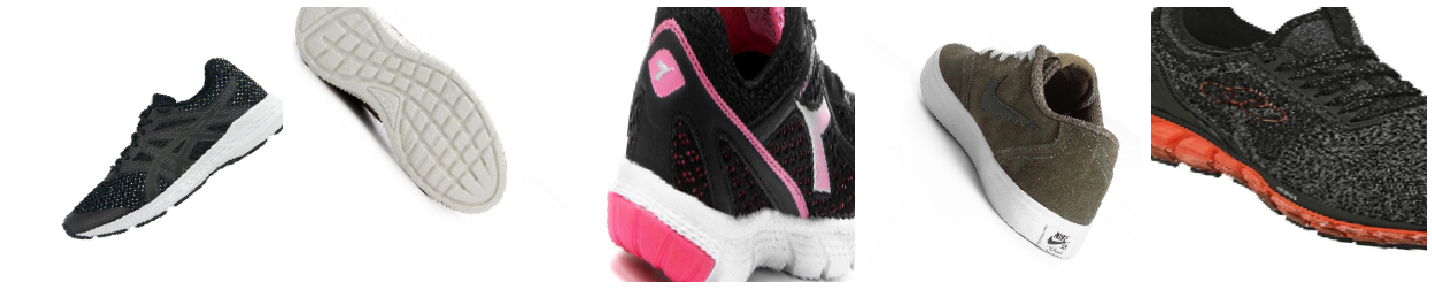

In [21]:
sample_training_images, _ = next(train_data_gen)

plot_images(sample_training_images[:5])

In [12]:
checkpoint_path

'./gender_model/drop35_lr2e4_adam_b1'

In [13]:
%tensorboard --logdir gender_model/drop35_lr2e4_adam_b1

In [14]:
learning_rate = 0.0002
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

logdir = f"{checkpoint_path}/logs/7/scalars/"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                       save_best_only=True,
                                       monitor='val_acc',
                                       mode='max',
                                       save_weights_only=False),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,profile_batch=0,update_freq='batch')
]



history = model.fit(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // train_data_gen.batch_size,
    epochs=310,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // val_data_gen.batch_size,
    callbacks=callbacks,
    initial_epoch=210
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 470 steps, validate for 62 steps
Epoch 211/310
469/470 [============================>.] - ETA: 1s - loss: 0.6097 - acc: 0.7253WARNING:tensorflow:From /home/raphael/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./gender_model/drop35_lr2e4_adam_b1/assets
470/470 [==============================] - 679s 1s/step - loss: 0.6098 - acc: 0.7255 - val_loss: 0.5686 - val_acc: 0.7568
Epoch 212/310
470/470 [==============================] - 644s 1s/step - loss: 0.6082 - acc: 0.7265 - val_loss: 0.5651 - val_acc: 0.7576
Epoch 213/310
470/470 [==============================] - 641s 1s/step - loss: 0.6073 - acc: 0.7259 - va

INFO:tensorflow:Assets written to: ./gender_model/drop35_lr2e4_adam_b1/assets
470/470 [==============================] - 613s 1s/step - loss: 0.5898 - acc: 0.7335 - val_loss: 0.5591 - val_acc: 0.7608
Epoch 254/310
470/470 [==============================] - 608s 1s/step - loss: 0.5925 - acc: 0.7328 - val_loss: 0.5612 - val_acc: 0.7555
Epoch 255/310
470/470 [==============================] - 608s 1s/step - loss: 0.5890 - acc: 0.7347 - val_loss: 0.5596 - val_acc: 0.7601
Epoch 256/310
470/470 [==============================] - 608s 1s/step - loss: 0.5937 - acc: 0.7289 - val_loss: 0.5602 - val_acc: 0.7601
Epoch 257/310
470/470 [==============================] - 609s 1s/step - loss: 0.5889 - acc: 0.7345 - val_loss: 0.5600 - val_acc: 0.7586
Epoch 258/310
470/470 [==============================] - 609s 1s/step - loss: 0.5885 - acc: 0.7366 - val_loss: 0.5615 - val_acc: 0.7555
Epoch 259/310
470/470 [==============================] - 608s 1s/step - loss: 0.5874 - acc: 0.7354 - val_loss: 0.5597 - 

Epoch 302/310
470/470 [==============================] - 611s 1s/step - loss: 0.5795 - acc: 0.7415 - val_loss: 0.5518 - val_acc: 0.7626
Epoch 303/310
470/470 [==============================] - 611s 1s/step - loss: 0.5844 - acc: 0.7369 - val_loss: 0.5558 - val_acc: 0.7545
Epoch 304/310
470/470 [==============================] - 610s 1s/step - loss: 0.5765 - acc: 0.7433 - val_loss: 0.5528 - val_acc: 0.7586
Epoch 305/310
470/470 [==============================] - 611s 1s/step - loss: 0.5772 - acc: 0.7422 - val_loss: 0.5523 - val_acc: 0.7611
Epoch 306/310
470/470 [==============================] - 611s 1s/step - loss: 0.5764 - acc: 0.7439 - val_loss: 0.5538 - val_acc: 0.7608
Epoch 307/310
470/470 [==============================] - 610s 1s/step - loss: 0.5731 - acc: 0.7426 - val_loss: 0.5586 - val_acc: 0.7540
Epoch 308/310
470/470 [==============================] - 610s 1s/step - loss: 0.5812 - acc: 0.7383 - val_loss: 0.5567 - val_acc: 0.7548
Epoch 309/310
470/470 [=========================

In [7]:
model = tf.keras.models.load_model(checkpoint_path)

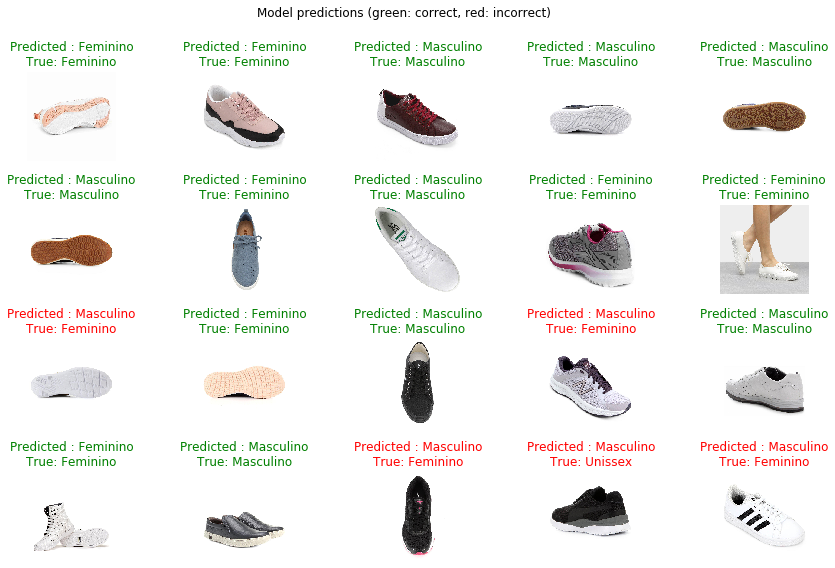

In [24]:
class_names = sorted(train_data_gen.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])

image_batch, label_batch = test_data_gen.next()

predicted_batch = model.predict(image_batch)
real_id = np.argmax(label_batch,axis=-1)
real_label_batch = class_names[real_id]
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(15,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(4,5,n+1)
    plt.imshow(image_batch[n])
    color = "green" if predicted_id[n] == label_id[n] else "red"
    plt.title(f"Predicted : {predicted_label_batch[n].title()}\nTrue: {real_label_batch[n].title()}",
              color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")
plt.show()

In [17]:
# Evaluation on whole val set
model.evaluate(val_data_gen)

# Evaluation on whole test set
model.evaluate(test_data_gen)

  ...
    to  
  ['...']
63/63 [==============================] - 49s 775ms/step - loss: 0.5583 - acc: 0.7644
  ...
    to  
  ['...']
21/21 [==============================] - 18s 860ms/step - loss: 0.5767 - acc: 0.7447


[0.5766765191441491, 0.7447289]

In [18]:
def report(data_gen,model):
    real= []
    predicted = []
    steps = data_gen.samples // data_gen.batch_size
    data_gen.reset()
    for step in tqdm_notebook(range(steps)):
        image_batch, label_batch = data_gen.next()
        predicted_batch = model.predict(image_batch)

        real_id = np.argmax(label_batch,axis=-1)
        real_label_batch = class_names[real_id]

        predicted_id = np.argmax(predicted_batch, axis=-1)
        predicted_label_batch = class_names[predicted_id]

        real.extend(real_label_batch)
        predicted.extend(predicted_label_batch)

    print(classification_report(real,predicted))

In [19]:
report(val_data_gen,model)


              precision    recall  f1-score   support

    Feminino       0.82      0.72      0.77      1829
   Masculino       0.73      0.86      0.79      1925
     Unissex       0.67      0.32      0.44       214

    accuracy                           0.76      3968
   macro avg       0.74      0.63      0.66      3968
weighted avg       0.77      0.76      0.76      3968



In [ ]:
report(test_data_gen,model)